<a href="https://colab.research.google.com/github/herysedra/ady_cov/blob/master/scr/modely_RP/R_Tana_tabilao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [23]:
!pip install pynverse

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import pickle

import datetime
import time
from datetime import date

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

from numpy import log,exp
from numpy.random import multinomial
from scipy.stats import uniform, gamma, gengamma, poisson, nbinom, expon
from scipy.integrate import quad


from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


from pynverse import inversefunc

tilyvoa = pd.read_csv("/content/drive/My Drive/data/tilyvoa.csv")

mdg_databe = pd.read_csv("/content/drive/My Drive/data/databe mdg.csv")

#tilyvoa.set_index('Daty', inplace=True)

tilyvoafar = tilyvoa.groupby('Faritra')

tilyvoamdg = tilyvoafar.get_group('Madagasikara')
tilyvoamdg.set_index('Daty', inplace=True)
tilyvoamdg.index = pd.to_datetime(tilyvoamdg.index)

tilyvoatana = tilyvoafar.get_group('Antananarivo')
tilyvoatana.set_index('Daty', inplace=True)
tilyvoatana.index = pd.to_datetime(tilyvoatana.index)

tilyvoatoa = tilyvoafar.get_group('Toamasina')
tilyvoatoa.set_index('Daty', inplace=True)
tilyvoatoa.index = pd.to_datetime(tilyvoatoa.index)


path_to_save = '/content/drive/My Drive/sary/'
path_data = '/content/drive/My Drive/data/'

In [0]:
# Voa vaovao (observed incidence)
Ivaotana = tilyvoatana['Voatomb']

dIvao = pd.DataFrame(data =Ivaotana)

dIvao['Datint'] = range(len(Ivaotana))


# Hoan'ny taha sorisoritry ny fifindrana (infectioness profile distribution)

daty_data_manom = datetime.date(2020,5,6)
daty_data_mifar = datetime.date(2020,6,9)

datyt = daty_data_mifar - datetime.timedelta(days = 1)

format_date = lambda date_py: '{}-{}-{}'.format(date_py.year, date_py.month, date_py.day)
datyf_data_manom = format_date(daty_data_manom)
datyf_data_mifar = format_date(daty_data_mifar)

# Discretization of the serial interval distribution

#Tombana mialoha (prior distributions)
#si_sh = 1/(0.62**2) # Report 13
#si_sc = 6.5/si_sh

si_sh = (6.48**2)/(3.83**2) # Planning tool: Short-term forecasts
si_sc = 6.48/si_sh

def discr_si(t):
  if t == 0:
    discrsi = 0
  elif t == 1:
    discrsi = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)
  else:
    discrsi = gengamma.cdf(t+1/2, si_sh, 1, loc = 0, scale = si_sc) - gengamma.cdf(t-1/2, si_sh, 1, loc = 0, scale = si_sc)
  return discrsi

#discr_si1 = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)

# 1/ The total incidence over a generic window (t-k+1,t)
# Ireh(t,k) = sum(i = 0 to k-1) Ivao(t - i))

def Ireh(t,k):
  Irehv = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      Irehv = Irehv + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]
  else:
    for i in range(k):
      Irehv = Irehv + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]
  return Irehv

# 2/ Tool to compute the total infectiousness over a generic window (t-k+1,t)
# Isi(t,k) = sum(i=0 to k-1) Ivao(t - i)*discr_si(i)

# The definition of Isi(t,k) does not include the term Ivao(t) for i = 0 (because discr_si(0) =0) 
# but include the last term Ivao(t - k + 1)*discr_si(k - 1) for i = k-1. 

def Isi(t,k):
  Ivaosi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      Ivaosi = Ivaosi + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  else:
    for i in range(k):
      Ivaosi = Ivaosi + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  return Ivaosi

# The total infectiousness before t

# lsi(t) := sum(i=0 to t-1) Ivao(t - i)*discr_si(i)

def lsi(t):
  return Isi(t, (t - daty_data_manom).days +1)

  # for checking, take for example t = daty_data_manom + datetime.timedelta(days = 3)

# 3/ The sum of total infectiousness before t over a generic window (t-k+1,t)
# tlsi(t) := sum(i=t-k+1 to t)lsi(i)

def tlsi(t,k):
  tlsi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  else:
    for i in range(k):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  return tlsi

# 4/ The shape parameters of the posterior predictive negative binomial of I(t+1)

# pnb(t,k) = Isi(t+1, t - daty_data_manom + 2)*(1/si_sc + Isi(t,k))/(1 + si(t+1, t - daty_data_manom + 2)*(1/si_sc + Isi(t,k)))

def pnb(t,k):
  return lsi(t+datetime.timedelta(days = 1))*(1/si_sc + tlsi(t,k))/(1 + lsi(t+datetime.timedelta(days = 1))*(1/si_sc + tlsi(t,k)))

# pnb(t,k) dia ny taha herjika hoan'ny NB hoan'ny I(t+1).

# 5/ Use the pmf of the posterior predictive negative binomial to compute
# each additive contribution at time s then for-loop for s in the time interval

def lpr(t,k):
  return -np.log(nbinom.pmf(dIvao['Voatomb'].loc[format_date(t + datetime.timedelta(days = 1))], si_sh + Ireh(t,k), pnb(t,k)))


In [12]:
# 6/ Computation of the Accumulated Predictive Error

# APE9_part1 

# for i in range(8):
# t = t_mif - i - 1
# k = 9

APEt91 = []
Prt91 = []

APE91 = 0

for i in range(round(((daty_data_mifar - daty_data_manom).days + 1)/2) - 1):
  t = daty_data_mifar - datetime.timedelta(days = i+1) 
  k = round(((daty_data_mifar - daty_data_manom).days + 1)/2)
  APE91 = APE91 + lpr(t,k)
  APEt91.append((lpr(t,k),t))
  Prt91.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE91 =', APE91)
print('APEt91 =', APEt91)
print('Prt91 =', Prt91)

# APE9_part2 

# for i in range(9):
# t = t_mif - 1 - 9 + 1 - i
# k = t_mif - t - 2*i
APEt92 = []
Prt92 = []

APE92 = 0
for i in range(round(((daty_data_mifar - daty_data_manom).days + 1)/2)-1):
  t = daty_data_mifar - datetime.timedelta(days = 1) - datetime.timedelta(days = ((daty_data_mifar - daty_data_manom).days + 1)/2) + datetime.timedelta(days = 1) - datetime.timedelta(days = i)
  k = (daty_data_mifar - t - datetime.timedelta(days = 2*i)).days
  APE92 = APE92 + lpr(t,k) 
  APEt92.append((lpr(t,k) ,t,k))
  Prt92.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE92 =', APE92)
print('APEt92=', APEt92)
print('Prt92=', Prt92)

# For t_man such that Ivao(t_man) = Ivao(t_man + 1) = 0, lsi(t_man + 1) = tlsi(t_man + 1, 2) = Ireh(t_man + 1, 2) = 0
# so that pnb(t_man + 1, 2) = 0 and 

For k = 9, APE91 = 699.2284726883234
APEt91 = [(11.37725125931054, datetime.date(2020, 6, 8)), (159.7919249298352, datetime.date(2020, 6, 7)), (57.03532662378259, datetime.date(2020, 6, 6)), (123.19264002440191, datetime.date(2020, 6, 5)), (15.166983275122686, datetime.date(2020, 6, 4)), (10.853225342041984, datetime.date(2020, 6, 3)), (80.65961220224429, datetime.date(2020, 6, 2)), (4.190578042246456, datetime.date(2020, 6, 1)), (12.477619002544959, datetime.date(2020, 5, 31)), (28.520972943612513, datetime.date(2020, 5, 30)), (89.47845775268942, datetime.date(2020, 5, 29)), (1.493527496779227, datetime.date(2020, 5, 28)), (29.464280246744472, datetime.date(2020, 5, 27)), (22.230359059449427, datetime.date(2020, 5, 26)), (25.066170975809687, datetime.date(2020, 5, 25)), (3.010856536323784, datetime.date(2020, 5, 24)), (25.218686975384383, datetime.date(2020, 5, 23))]
Prt91 = [1.1453086977139846e-05, 4.0109638729255715e-70, 1.6977446623788068e-25, 3.148590830276822e-54, 2.5885875406048

In [9]:
# APEk part 1 for k =/= 9

# for i in range(t_mif - t_man -j)

APEk1 = []
#APEt21 = []
for j in range(2,9):
  APEj1 = 0
  for i in range(round(((daty_data_mifar - daty_data_manom).days) - j)):
    t = daty_data_mifar - datetime.timedelta(days = i+1) 
    k = j
    APEj1 = APEj1 + lpr(t,k)
   # APEt21.append(lpr(t,k))
  APEk1.append(APEj1)

print('APEk1 =', APEk1)
#print('APEt21 =', APEt21)

# APEk part 2 for k =/= 9

Prk2 = []

APEk2 = []

for j in range(2,9):
  APEj2 = 0
  for i in range(j-1):
    t = daty_data_manom + datetime.timedelta(days = j - i - 1)
    k = j - i
    APEj2 = APEj2 + lpr(t,k)
  APEk2.append(APEj2)

print('APEk2 =', APEk2)

APEk1 = [752.3829956031315, 760.2265412066874, 768.8533274998772, 778.2579897453819, 780.452434773223, 780.7861880963793, 774.7213765959198]
APEk2 = [9.388827469433236, 25.560522160678275, 35.88626212302235, 39.17313517638051, 45.66013594163164, 47.980751830290416, 49.80235769165111]


In [14]:
# APEk for k = 2,...,8

APEk = [x + y for x, y in zip(APEk1, APEk2)]

# APE9
APE9 = APE91 + APE92

APE = APEk + [APE9]
kk = APE.index(min(APE)) +2
print('APE9 =', APE9)
print('APEk =', APEk)
print('APE =', APE)
print(kk)


APE9 = 834.3558018668432
APEk = [761.7718230725646, 785.7870633673657, 804.7395896228995, 817.4311249217624, 826.1125707148547, 828.7669399266697, 824.5237342875708]
APE = [761.7718230725646, 785.7870633673657, 804.7395896228995, 817.4311249217624, 826.1125707148547, 828.7669399266697, 824.5237342875708, 834.3558018668432]
2


# Choice of the prior hyperparameters

In [0]:
  #shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh
  # Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc

def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[0.01, 1e+11])


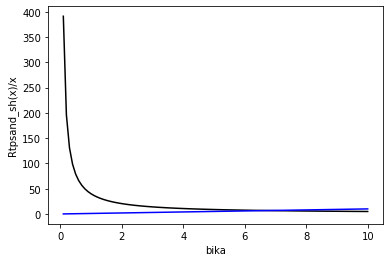

In [27]:
# Variation of Rtpsand_sh(x)/x

datyab = datetime.date(2020, 6, 9)

# 100 linearly spaced numbers
x = np.linspace(0.1,10,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x, func_sh(datyab)(x)/x, 'k')
plt.plot(x, x, 'b')

#ax.set_ylim(0, 5)
ax.set(xlabel ='bika', ylabel = "Rtpsand_sh(x)/x")


# show the plot
plt.show()

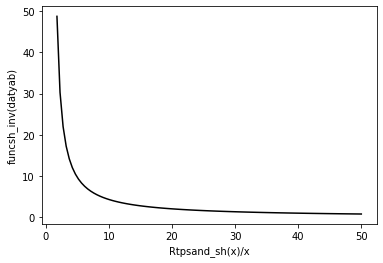

In [33]:
# Variation of funcsh_inv(datyab)


# 100 linearly spaced numbers
x = np.linspace(1.8,50,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x, funcsh_inv(datyab)(x), 'k')

ax.set(xlabel ='Rtpsand_sh(x)/x', ylabel = "funcsh_inv(datyab)")


# show the plot
plt.show()

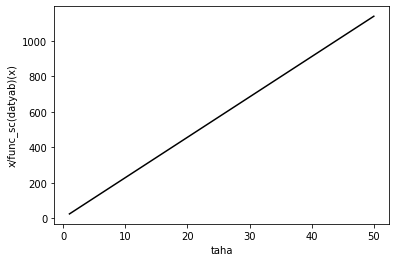

In [29]:
# Variation of x/funcsh_inv(datyab)(x)


# 100 linearly spaced numbers
x = np.linspace(1,50,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x, x/(func_sc(datyab)(x)), 'k')


ax.set(xlabel ='taha', ylabel = "x/func_sc(datyab)(x)")


# show the plot
plt.show()

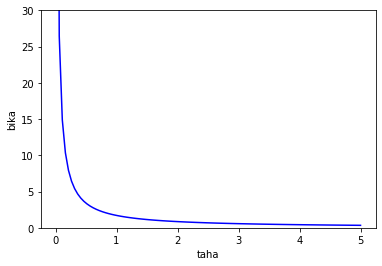

In [34]:
# Curve of (shape, scale) for which the prior mean is equal to the posterior mean

# 100 linearly spaced numbers
x = np.linspace(0.01,5,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x, funcsh_inv(datyab)(x/func_sc(datyab)(x)+0.1), 'blue')

ax.set_ylim(0,30)
ax.set(xlabel ='taha', ylabel = "bika")

plt.savefig(path_to_save+'ab76.eps')

# show the plot
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


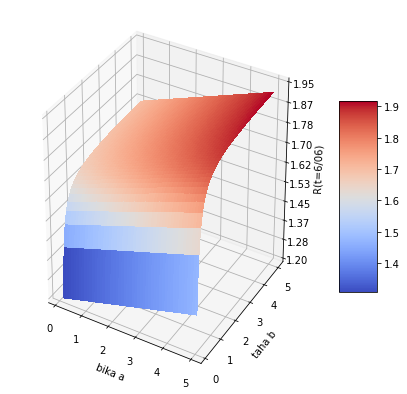

In [79]:
# Variation of R(datyab) with rapport to the prior parameters

fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')

# Make data.
X = np.linspace(0.1,5,100)
Y = np.linspace(0.1,5,100)
X, Y = np.meshgrid(X, Y)
Z = func_sh(datyab)(X)*func_sc(datyab)(Y)
W = X*Y
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#surf = ax.plot_surface(X, Y, W, cmap=cm.coolwarm,
 #                      linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(1.2, 1.95)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set(xlabel ='bika a', ylabel = "taha b", zlabel = 'R(t=6/06)')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.savefig(path_to_save+'Rt3596_anta.eps')

plt.show()

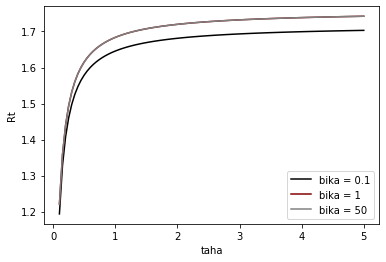

In [41]:
# Variation of R(t) with rapport to the shape parameter a

# 100 linearly spaced numbers
x = np.linspace(0.1,5,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the functions
plt.plot(x, func_sh(datyab)(0.1)*func_sc(datyab)(x), 'k', label ="bika = 0.1")
plt.plot(x, func_sh(datyab)(1)*func_sc(datyab)(x), 'maroon', label= 'bika = 1')
plt.plot(x, func_sh(datyab)(1)*func_sc(datyab)(x), 'grey', label= 'bika = 50')

ax.set(xlabel ='taha', ylabel = "Rt")
ax.legend(loc= 'lower right')

# show the plot
plt.show()

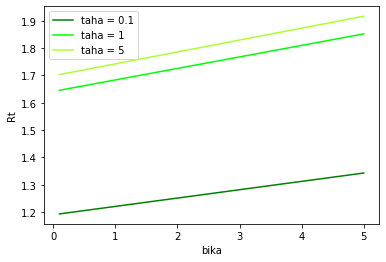

In [42]:
# Variation of R(t) with rapport to the shape prior parameter a

# 100 linearly spaced numbers
x = np.linspace(0.1,5,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the functions
plt.plot(x, func_sh(datyab)(x)*func_sc(datyab)(0.1), 'green', label ="taha = 0.1")
plt.plot(x, func_sh(datyab)(x)*func_sc(datyab)(1), 'lime',  label ="taha = 1")
plt.plot(x, func_sh(datyab)(x)*func_sc(datyab)(5), 'greenyellow', label ="taha = 5")

ax.set(xlabel ='bika', ylabel = "Rt")
ax.legend(loc= 'upper left')


# show the plot
plt.show()

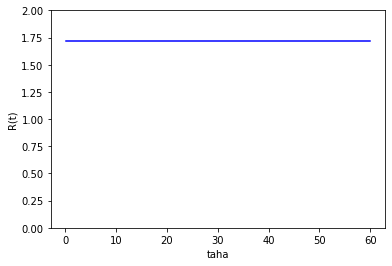

taha* = 1
R(t= 2020-06-09 ) = 1.7136929431440402 = bika*


In [44]:
# R(t) when equality between the prior and the posterior

# 100 linearly spaced numbers
x = np.linspace(0.1,60,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x, x*funcsh_inv(datyab)(x/func_sc(datyab)(x)), 'blue')

ax.set_ylim(0,2)
ax.set(xlabel ='taha', ylabel = "R(t)")


# show the plot
plt.show()

print('taha* = 1')
print('R(t=',datyab,') =', funcsh_inv(datyab)(1/func_sc(datyab)(1)), '= bika*')


# Two regions for the prior parameters 

## Blue area

In [45]:
# Prior Gamma distribution of Rt

Rtpr_sh = 0.1 # shape
Rtpr_sc = 0.1 # scale

# Posterior distribution for Rt

# Shape parameter :
def Rtps_sh(t):
   return Rtpr_sh + Ireh(t,kk)

# Scale
def Rtps_sc(t):
  return 1/(1/Rtpr_sc + tlsi(t,kk))

# mean
def Rtps_salan(t):
  return Rtps_sh(t)*Rtps_sc(t)

# 95th and 5th percentiles

def perc95st(t):
  return gengamma.ppf(0.95, Rtps_sh(t), 1, loc = 0, scale = Rtps_sc(t))

def perc05st(t):
  return gengamma.ppf(0.05, Rtps_sh(t), 1, loc = 0, scale = Rtps_sc(t))


def Rtps_sal(t):
  return dIvao['Voatomb'].loc[format_date(t)]/lsi(t)

print("Kajy mivantana ny R hoan'ny", datyt, ':', Rtps_sal(datyt))

print("Salan'isa R hoan'ny", datyt, ':', Rtps_salan(datyt))

Kajy mivantana ny R hoan'ny 2020-06-08 : 3.328682940195069
Salan'isa R hoan'ny 2020-06-08 : 1.6631010776070716


In [0]:
# Plotting everything except the first 7 days

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst = []

salan_Rt = []
perc95st_lst = []
perc05st_lst = []

salan_Rt_dat = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) - 1 -7)):
  t = daty_data_manom + datetime.timedelta(days = i+1 +7)
  daty = formatf_date(t)
  daty_lst.append(daty)
  salan_Rt.append(Rtps_salan(t))
  perc95st_lst.append(perc95st(t))
  perc05st_lst.append(perc05st(t))
  salan_Rt_dat.append((Rtps_salan(t),t))


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


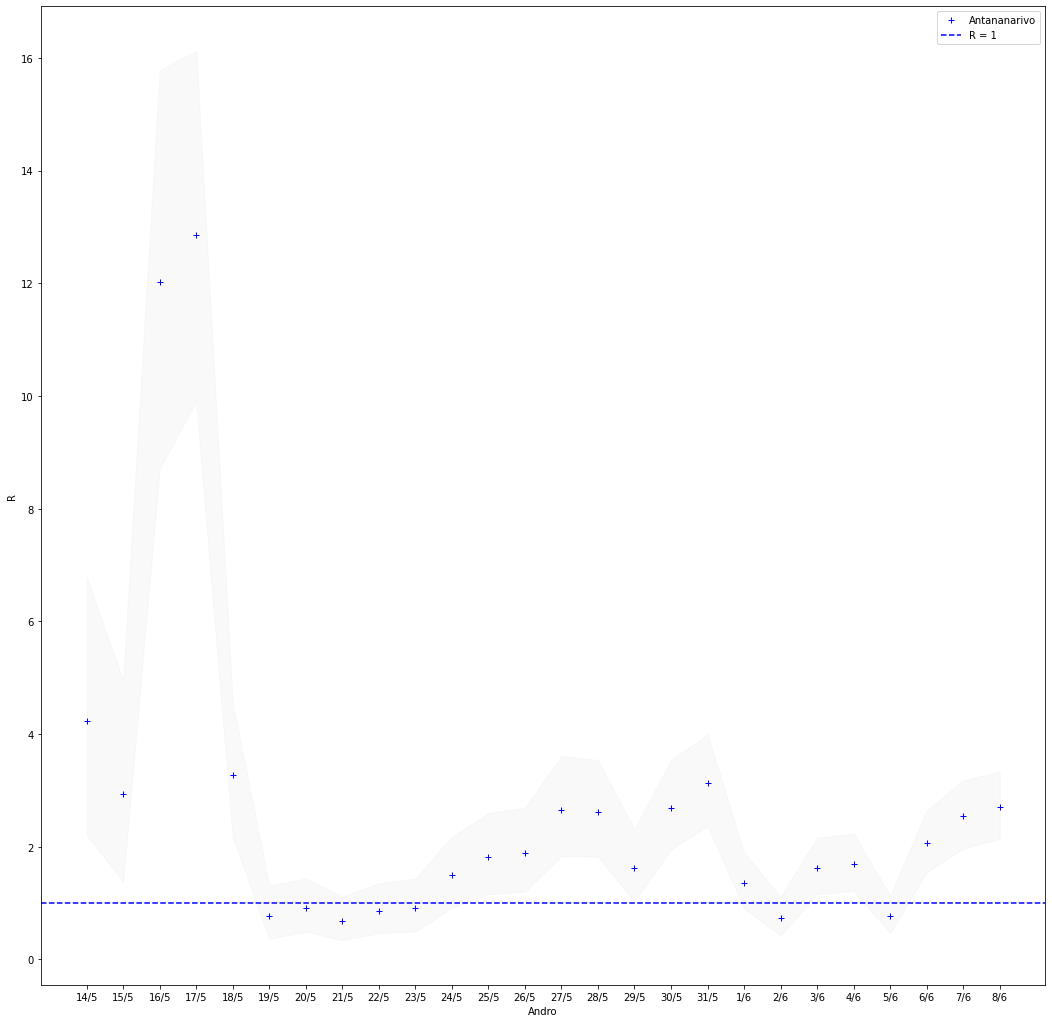

In [84]:
# Plotting everything

fig, ax = plt.subplots(figsize=(18, 18))

ax.plot(daty_lst, salan_Rt, 'b',  marker ="+",ls = 'None', label = 'Antananarivo')
#ax.plot(daty_lst, sal_Rt, 'green',  marker =9,ls = 'None')
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")
ax.fill_between(daty_lst, perc05st_lst, perc95st_lst, alpha=0.04, color="tab:grey")

ax.set(xlabel ='Andro', ylabel = "R")
ax.legend(loc= 'best')

plt.savefig(path_to_save+'Rt3596g_anta.eps')
plt.show()

In [0]:
# Plotting for the last 10 days before daty_data_mifar

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst10 = []
salan_Rt10 = []
perc95st_lst10 = []
perc05st_lst10 = []

for i in range(10):
  t = daty_data_mifar - datetime.timedelta(days = i+1)
  daty = formatf_date(t)
  daty_lst10.append(daty)
  perc95st_lst10.append(perc95st(t))
  perc05st_lst10.append(perc05st(t))
  salan_Rt10.append(Rtps_salan(t))

daty_lst10.reverse()
salan_Rt10.reverse()
perc95st_lst10.reverse()
perc05st_lst10.reverse()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


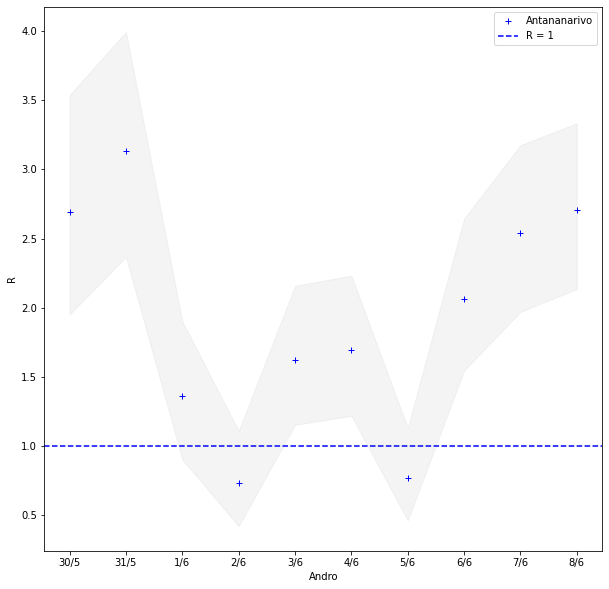

In [86]:
# Plotting of the last 10 days from daty_data_mifar

fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(daty_lst10, salan_Rt10, 'b',  marker ="+",ls = 'None', label = 'Antananarivo')
#ax.plot(daty_lst, sal_Rt, 'green',  marker =9,ls = 'None')
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")
ax.fill_between(daty_lst10, perc05st_lst10, perc95st_lst10, alpha=0.08, color="tab:grey")

ax.set(xlabel ='Andro', ylabel = "R")
ax.legend(loc= 'best')

plt.savefig(path_to_save+'R359610g_anta.eps')
plt.show()

## Red area

In [87]:
# Prior Gamma distribution of Rt

Rtpr_sh = 5 # shape
Rtpr_sc = 5 # scale

# Posterior distribution for Rt

# Shape parameter :
def Rtps_sh(t):
   return Rtpr_sh + Ireh(t,kk)

# Scale
def Rtps_sc(t):
  return 1/(1/Rtpr_sc + tlsi(t,kk))

# mean
def Rtps_salan(t):
  return Rtps_sh(t)*Rtps_sc(t)

# 95th and 5th percentiles

def perc95st(t):
  return gengamma.ppf(0.95, Rtps_sh(t), 1, loc = 0, scale = Rtps_sc(t))

def perc05st(t):
  return gengamma.ppf(0.05, Rtps_sh(t), 1, loc = 0, scale = Rtps_sc(t))


def Rtps_sal(t):
  return dIvao['Voatomb'].loc[format_date(t)]/lsi(t)

print("Kajy mivantana ny R hoan'ny", datyt, ':', Rtps_sal(datyt))

print("Salan'isa R hoan'ny", datyt, ':', Rtps_salan(datyt))

Kajy mivantana ny R hoan'ny 2020-06-08 : 3.328682940195069
Salan'isa R hoan'ny 2020-06-08 : 2.706100708968946


In [0]:
# Plotting everything except the first 7 days

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst = []

salan_Rt = []
perc95st_lst = []
perc05st_lst = []

salan_Rt_dat = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) - 1 -7)):
  t = daty_data_manom + datetime.timedelta(days = i+1 +7)
  daty = formatf_date(t)
  daty_lst.append(daty)
  salan_Rt.append(Rtps_salan(t))
  perc95st_lst.append(perc95st(t))
  perc05st_lst.append(perc05st(t))
  salan_Rt_dat.append((Rtps_salan(t),t))


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


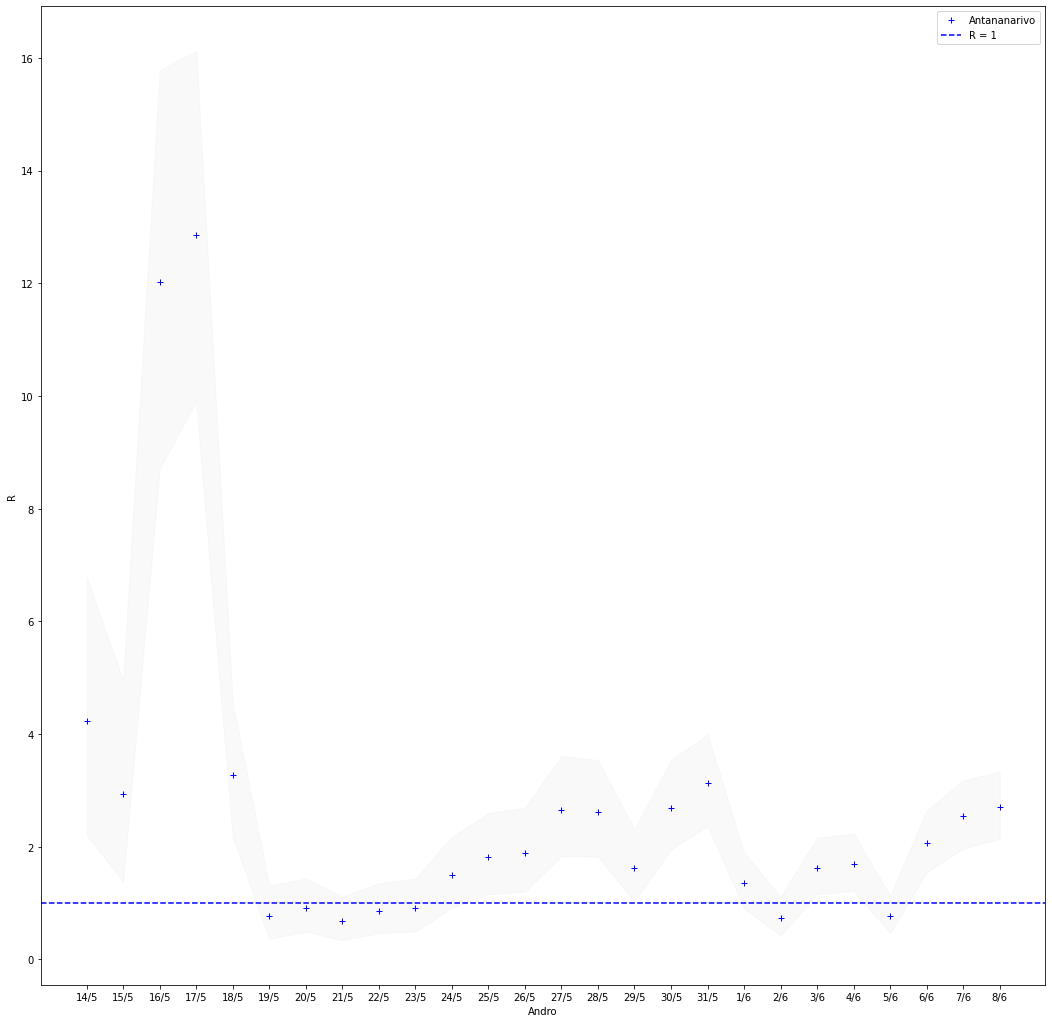

In [90]:
# Plotting everything except the first 

fig, ax = plt.subplots(figsize=(18, 18))

ax.plot(daty_lst, salan_Rt, 'b',  marker ="+",ls = 'None', label = 'Antananarivo')
#ax.plot(daty_lst, sal_Rt, 'green',  marker =9,ls = 'None')
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")
ax.fill_between(daty_lst, perc05st_lst, perc95st_lst, alpha=0.04, color="tab:grey")

ax.set(xlabel ='Andro', ylabel = "R")
ax.legend(loc= 'best')

plt.savefig(path_to_save+'Rt1496m_anta.eps')
plt.show()

In [0]:
# Plotting for the last 10 days from daty_data_mifar

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst10 = []
salan_Rt10 = []
perc95st_lst10 = []
perc05st_lst10 = []

for i in range(10):
  t = daty_data_mifar - datetime.timedelta(days = i+1)
  daty = formatf_date(t)
  daty_lst10.append(daty)
  perc95st_lst10.append(perc95st(t))
  perc05st_lst10.append(perc05st(t))
  salan_Rt10.append(Rtps_salan(t))

daty_lst10.reverse()
salan_Rt10.reverse()
perc95st_lst10.reverse()
perc05st_lst10.reverse()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


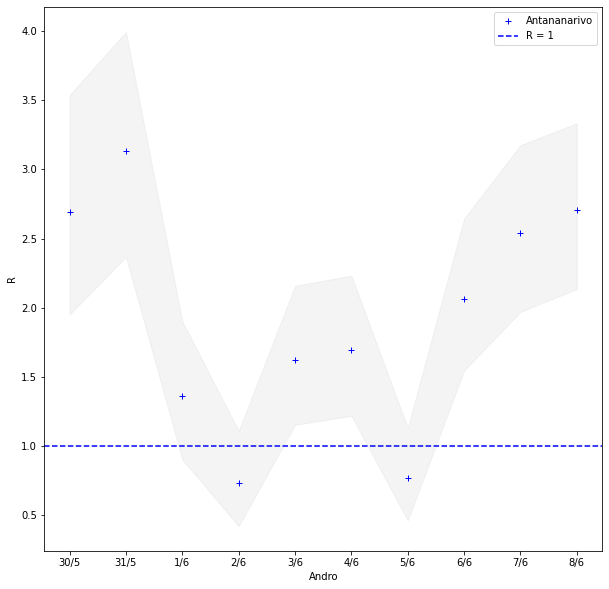

In [61]:
# Plotting of the last 10 days from daty_data_mifar

fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(daty_lst10, salan_Rt10, 'b',  marker ="+",ls = 'None', label = 'Antananarivo')
#ax.plot(daty_lst, sal_Rt, 'green',  marker =9,ls = 'None')
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")
ax.fill_between(daty_lst10, perc05st_lst10, perc95st_lst10, alpha=0.08, color="tab:grey")

ax.set(xlabel ='Andro', ylabel = "R")
ax.legend(loc= 'best')

plt.savefig(path_to_save+'R359610m_anta.eps')
plt.show()

# Prior parameters corresponding to the equality of prior and posterior means

In [92]:
#shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh

# Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc


def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[1e-11, 1e+11])

def Rt_salan(t):
    ffunc_sh = func_sh(t)
    ffunc_sc = func_sc(t)
    ffuncsh_inv = funcsh_inv(t)
    return ffuncsh_inv(1/ffunc_sc(1))

# The 95th and 5th percentiles of Rt

def perc95(t):
    return gengamma.ppf(0.95, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

def perc05(t):
    return gengamma.ppf(0.05, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

print("Salan'isa R hoan'ny", datyt, ':', Rt_salan(datyt))

Salan'isa R hoan'ny 2020-06-08 : 2.4845403238629427


In [93]:
# Plotting everything except the first 7 days

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst = []
salan_Rt_lst = []
perc95_lst = []
perc05_lst = []
salan_Rt_daty_lst = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) - 1 -7)):
  t = daty_data_manom + datetime.timedelta(days = i+1 +7)
  daty = formatf_date(t)
  daty_lst.append(daty)
  perc95_lst.append(perc95(t))
  perc05_lst.append(perc05(t))
  salan_Rt_lst.append(Rt_salan(t))
  salan_Rt_daty_lst.append((Rt_salan(t),daty))

print('(array(R(t)), daty) =', salan_Rt_daty_lst)

(array(R(t)), daty) = [(array(2.07639422), '14/5'), (array(0.91296285), '15/5'), (array(10.92892566), '16/5'), (array(12.13765116), '17/5'), (array(2.53784399), '18/5'), (array(0.22740971), '19/5'), (array(0.46503701), '20/5'), (array(0.25951466), '21/5'), (array(0.43779958), '22/5'), (array(0.464946), '23/5'), (array(1.01291559), '24/5'), (array(1.3104256), '25/5'), (array(1.36182204), '26/5'), (array(2.15375477), '27/5'), (array(2.14171155), '28/5'), (array(1.16224023), '29/5'), (array(2.29972896), '30/5'), (array(2.78716366), '31/5'), (array(1.03699615), '1/6'), (array(0.43191234), '2/6'), (array(1.34878997), '3/6'), (array(1.42708851), '4/6'), (array(0.49833757), '5/6'), (array(1.81272995), '6/6'), (array(2.3018208), '7/6'), (array(2.48454032), '8/6')]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


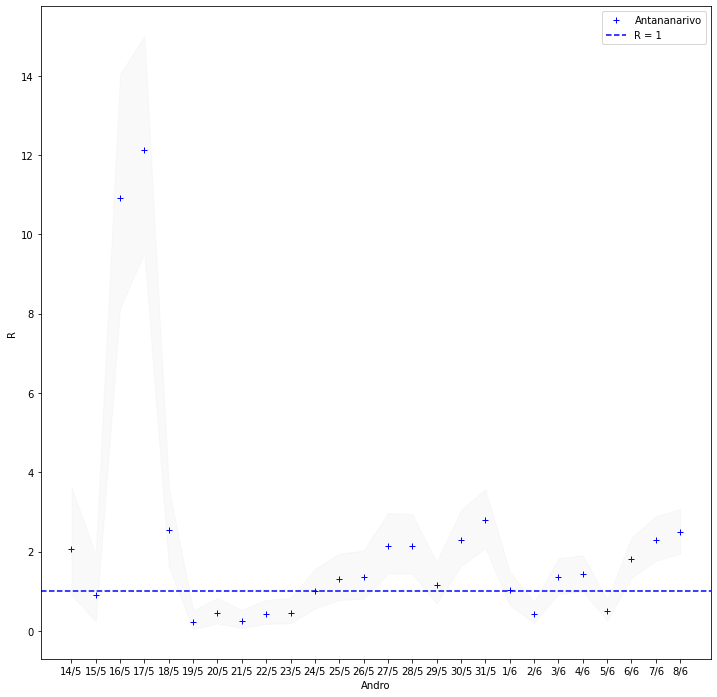

In [94]:
# Plotting everything

fig, ax = plt.subplots(figsize=(12, 12))

ax.plot(daty_lst, salan_Rt_lst, 'b',  marker ="+",ls = 'None', label = 'Antananarivo')
#ax.plot(daty_lst, sal_Rt, 'green',  marker =9,ls = 'None')
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")
ax.fill_between(daty_lst, perc05_lst, perc95_lst, alpha=0.04, color="tab:grey")

ax.set(xlabel ='Andro', ylabel = "R")
ax.legend(loc= 'best')

plt.savefig(path_to_save+'R3596_anta.eps')
plt.show()

In [77]:
# Plotting for the last 10 days from daty_data_mifar

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst10 = []
salan_Rt_lst10 = []
perc95_lst10 = []
perc05_lst10 = []
salan_Rt_daty_lst10 = []

for i in range(10):
  t = daty_data_mifar - datetime.timedelta(days = i+1)
  daty = formatf_date(t)
  daty_lst10.append(daty)
  perc95_lst10.append(perc95(t))
  perc05_lst10.append(perc05(t))
  salan_Rt_lst10.append(Rt_salan(t))
  salan_Rt_daty_lst10.append((Rt_salan(t),daty))

daty_lst10.reverse()
salan_Rt_lst10.reverse()
perc95_lst10.reverse()
perc05_lst10.reverse()
salan_Rt_daty_lst10.reverse()

print('(array(R(t)), daty) =', salan_Rt_daty_lst10)


(array(R(t)), daty) = [(array(2.29972896), '30/5'), (array(2.78716366), '31/5'), (array(1.03699615), '1/6'), (array(0.43191234), '2/6'), (array(1.34878997), '3/6'), (array(1.42708851), '4/6'), (array(0.49833757), '5/6'), (array(1.81272995), '6/6'), (array(2.3018208), '7/6'), (array(2.48454032), '8/6')]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


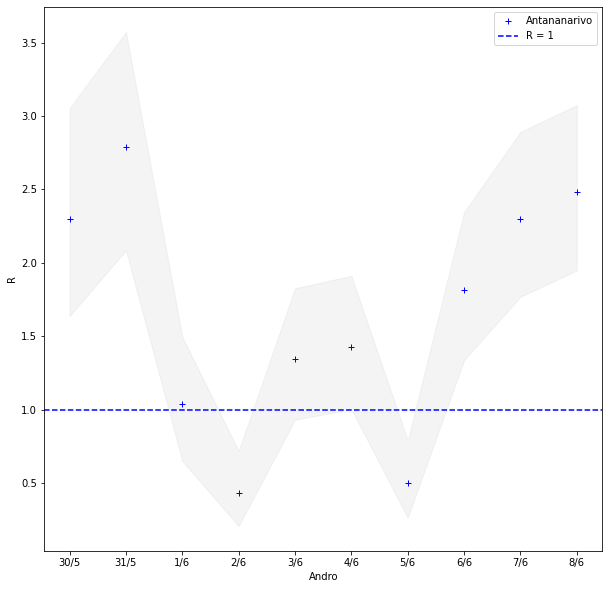

In [95]:
# Plotting of the last 10 days from daty_data_mifar

fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(daty_lst10, salan_Rt_lst10, 'b',  marker ="+",ls = 'None', label = 'Antananarivo')
#ax.plot(daty_lst, sal_Rt, 'green',  marker =9,ls = 'None')
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")
ax.fill_between(daty_lst10, perc05_lst10, perc95_lst10, alpha=0.08, color="tab:grey")

ax.set(xlabel ='Andro', ylabel = "R")
ax.legend(loc= 'best')

plt.savefig(path_to_save+'R359610_anta.eps')
plt.show()